<a href="https://colab.research.google.com/github/ZuzannaNogala/MCARD/blob/master/MCARD_Nogala_Zuzanna_l3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIST NR 3: PCA, SVD, NCA, ICA

 <font face="Rage" size=2  >

 Zuzanna Nogala

In [14]:
from sklearn import datasets, decomposition
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_circles

# Q3.1 (**10 pts**)
* Consider MNIST dataset, but only digits 0,1,2. Perform PCA to 3d.


In [2]:
mnist = datasets.load_digits()

mnist_012classes_pos = np.isin(mnist.target, [0, 1, 2])

mnist_012points = mnist.data[mnist_012classes_pos]
mnist_labels = mnist.target[mnist_012classes_pos]
mnist_classes_names = [0, 1, 2]

In [3]:
PCA_3D = decomposition.PCA(n_components=3)
PCA_3D.fit(mnist_012points)
mnist_pca_reduced_3d = PCA_3D.transform(mnist_012points)

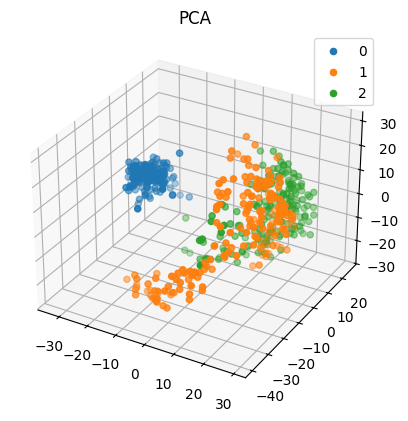

In [4]:
fig_PCA = plt.figure(1)
ax_PCA = fig_PCA.add_subplot(111, projection='3d')
ax_PCA.set_title("PCA")

for label in range(len(mnist_classes_names)):
    points_PCA = mnist_pca_reduced_3d[mnist_labels == label]
    ax_PCA.scatter(points_PCA[:, 0], points_PCA[:, 1], points_PCA[:, 2], label=mnist_classes_names[label])

ax_PCA.legend()
plt.show()

* NCA: optimize $(P1)$ for $\mathbf{A}$ (use Adam optimizer with `lr=0.05` for `1000` steps) to reduce points to 3d. Perform NCA with this $\mathbf{A}$.
Make three plots side-by-side: 1) NCA with "random A", 2) actual NCA, 3) PCA. Compare methods (by "eye inspection").

In [5]:
import torch

def loss_g(A, X, labels, eps=1e-12):
    """
    Computes the NCA loss for a given transformation matrix A, input data X, and labels.

    Args:
        A (torch.Tensor): Transformation matrix of shape (r, d).
        X (torch.Tensor): Data matrix of shape (d, n) where each column is a data point.
        labels (torch.Tensor): Labels tensor of shape (n,), with integer class labels.
        eps (float): A small value to prevent division by zero.

    Returns:
        torch.Tensor: The computed loss (scalar).
    """
    # Transform data: Y = A * X, resulting in shape: (r, n)
    X_prime = torch.matmul(A, X)
    X_prime_t = X_prime.t()  # shape: (n, r)

    # Compute squared Euclidean distances between all pairs of transformed points:
    # ||X_prime_i - X_prime_j||^2 = ||X_prime_i||^2 + ||X_prime_j||^2 - 2 * X_prime_i^T X_prime_j
    norm_sq = (X_prime_t ** 2).sum(dim=1, keepdim=True)  # shape: (n, 1)
    D = norm_sq + norm_sq.t() - 2 * torch.matmul(X_prime_t, X_prime_t.t())

    # Exclude self-comparison by setting the diagonal to a large value:
    n = X.shape[1]
    D = D + torch.eye(n, device=D.device) * 1e12

    # Stabilize the softmax: subtract the minimum value in each row from D.
    D_min, _ = D.min(dim=1, keepdim=True)
    D_stable = D - D_min

    # Compute the affinity using the Gaussian kernel: f(i,j) = exp(-D_stable(i,j))
    f = torch.exp(-D_stable)

    # Normalize to obtain probabilities p_{ij}
    sum_f = f.sum(dim=1, keepdim=True) + eps
    p = f / sum_f

    # Create a mask: mask[i, j] = 1 if labels[i] == labels[j], otherwise 0
    mask = (labels.unsqueeze(1) == labels.unsqueeze(0)).float()

    # Compute the objective: g(A) = sum_{i,j with same label} p_{ij}
    g_val = (p * mask).sum()

    # Since we maximize g(A), the loss is defined as the negative of g(A)
    loss = -g_val
    return loss

In [6]:
class NCA:

    def __init__(self, lr=0.05, n_epochs=1000, optimizer_name="Adam", device=None):

        self.lr = lr
        self.n_epochs = n_epochs
        self.optimizer_name = optimizer_name
        self.device = device if device is not None else torch.device("cpu")
        self.A = None
        self.loss_history = []
        self.A_history = []

    def fit(self, x_train, y_train, r, verbose=False):

        x_train_tensor = torch.tensor(x_train, dtype=torch.float32, device=self.device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=self.device)

        self.A = torch.nn.Parameter(torch.randn(r, x_train_tensor.shape[0], dtype=torch.float32, device=self.device))

        if self.optimizer_name.lower() == "sgd":
            optimizer = torch.optim.SGD([self.A], lr=self.lr)
        elif self.optimizer_name.lower() == "adam":
            optimizer = torch.optim.Adam([self.A], lr=self.lr)
        else:
            raise ValueError("Unsupported optimizer. Choose 'SGD' or 'Adam'.")

        # Reset histories
        self.loss_history = []
        self.A_history = []

        # Main training loop
        for epoch in range(self.n_epochs):
            loss = loss_g(self.A, x_train_tensor, y_train_tensor)

            # Backward pass: compute gradients.
            loss.backward()

            # Update parameters.
            optimizer.step()
            optimizer.zero_grad()

            # Record training history every 10 epochs.
            if epoch % 10 == 0:
                self.loss_history.append(loss.item())
                if verbose:
                    print(f"Epoch {epoch}: loss = {loss.item():.4f}")

        return self

    def transform(self, x):
        x_tensor = torch.tensor(x, dtype=torch.float32, device=self.device)
        return torch.matmul(self.A, x_tensor)

In [7]:
mnist_train, mnist_test, label_train, label_test = train_test_split(mnist_012points, mnist_labels, test_size=0.5, random_state=42)
_, d = mnist_train.shape

In [11]:
# PCA
PCA_3D_2 = decomposition.PCA(n_components=3)
PCA_3D_2.fit(mnist_train)
PCA_3D_2.fit(mnist_train)
mnist_pca_reduced_3d = PCA_3D_2.transform(mnist_test)

# NCA
model = NCA()
model.fit(mnist_train.T, label_train, r=3)
mnist_test_transformed3D = model.transform(mnist_test.T)

# NCA random
A = torch.rand((3, d))
mnist_test_transformed3D_random = torch.matmul(A, torch.tensor(mnist_test.T, dtype=torch.float32))

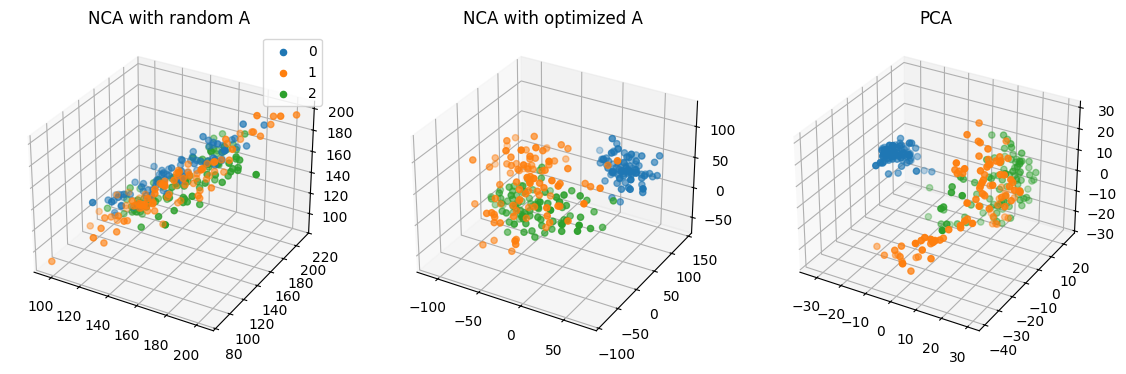

In [12]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax1.set_title("NCA with optimized A")

ax2 = fig.add_subplot(1, 3, 3, projection='3d')
ax2.set_title("PCA")

ax3 = fig.add_subplot(1, 3, 1, projection='3d')
ax3.set_title("NCA with random A")


for label in mnist_classes_names:
    points_NCA_opt = mnist_test_transformed3D.t()[label_test == label].detach().numpy()
    ax1.scatter(points_NCA_opt[:, 0], points_NCA_opt[:, 1], points_NCA_opt[:, 2], label=label)

    points_PCA = mnist_pca_reduced_3d[label_test == label]
    ax2.scatter(points_PCA[:, 0], points_PCA[:, 1], points_PCA[:, 2], label=label)

    points_NCA_rand = mnist_test_transformed3D_random.t()[label_test == label].detach().numpy()
    ax3.scatter(points_NCA_rand[:, 0], points_NCA_rand[:, 1], points_NCA_rand[:, 2], label=label)


plt.legend()
plt.show()

* Reconsider `X_circles`: convert each point $\mathbf{x}=(x,y)$ to $\mathbf{x'}=\left(x,y,\exp\left({x^2+y^2\over 1.25}\right)\right)$. Perform PCA to 1d and 2d. For 2d compare results with performing PCA and kernelPCA directly on original points.


In [15]:
X_circles, y_circles = make_circles(n_samples=1000, factor=0.3, noise=0.05, random_state=0)

Z = np.exp((X_circles[:, 0] ** 2 + X_circles[:, 1] ** 2) / 1.25)
X_prim = np.array([X_circles[:, 0], X_circles[:, 1], Z]).T

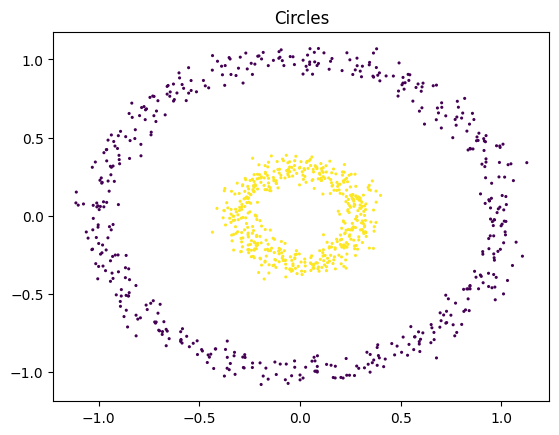

In [16]:
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, s=1.5)
plt.title("Circles")
plt.show()

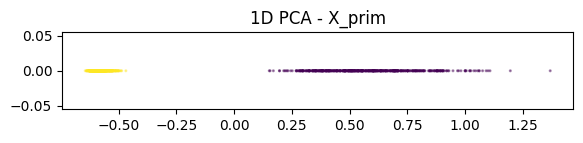

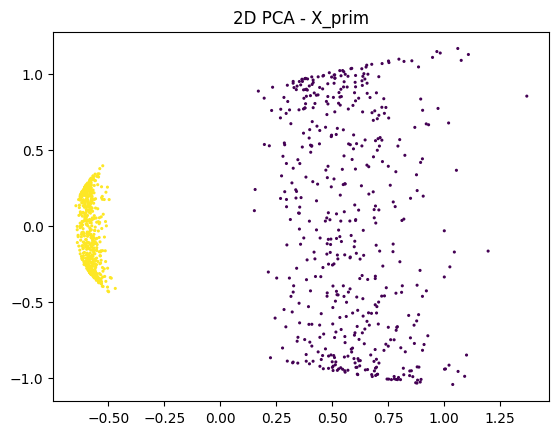

In [17]:
# PCA 1D on X_prim
PCA_prim_1d = decomposition.PCA(n_components=1)
PCA_prim_1d_fitted = PCA_prim_1d.fit_transform(X_prim)

plt.figure(figsize=(6.6, 1))
plt.scatter(PCA_prim_1d_fitted, np.zeros(PCA_prim_1d_fitted.shape[0]), c=y_circles, s=1.5, alpha=0.4)
plt.title("1D PCA - X_prim")
plt.show()

# PCA 2D  on X_prim
PCA_prim_2d = decomposition.PCA(n_components=2)
PCA_prim_2d_fitted = PCA_prim_2d.fit_transform(X_prim)

plt.scatter(PCA_prim_2d_fitted[:, 0], PCA_prim_2d_fitted[:, 1], c=y_circles, s=1.5)
plt.title("2D PCA - X_prim")
plt.show()

In [18]:
# PCA 2D on original X_circles
PCA_original_2d = decomposition.PCA(n_components=2)
PCA_2d_fitted = PCA_original_2d.fit_transform(X_circles)

# kernelPCA 2D on original X_circles
kernelPCA_original_2d = decomposition.KernelPCA(kernel="rbf", n_components=2)  # Radial
kernelPCA_2d_fitted = kernelPCA_original_2d.fit_transform(X_circles)

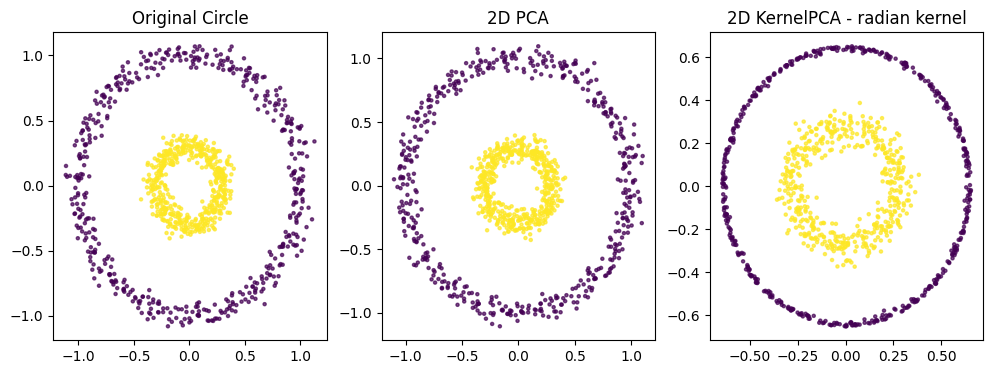

In [59]:
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("Original Circle")
ax1.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, alpha=0.7, s=5)

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(PCA_2d_fitted[:, 0], PCA_2d_fitted[:, 1], c=y_circles, alpha=0.7, s=5)
ax2.set_title("2D PCA")

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("2D KernelPCA - radian kernel")
ax3.scatter(kernelPCA_2d_fitted[:, 0], kernelPCA_2d_fitted[:, 1], c=y_circles, alpha=0.7, s=5)

plt.show()

# Q3.2 (**10 pts**)
* Construct $\mathbf{S}$ of size $3\times n$, each row correspond to an image (reshaped to a vector of size $n$)
* Consider mixing matrices:
$$\mathbf{A}_1=\left[\begin{array}{llll}
5 & 10 & 0 \\
10 & 0 & 40 \\
0 & 18 & 50
\end{array}\right],\qquad  
\mathbf{A}_2=\left[\begin{array}{llll}
1 & 1 & 0 \\
0 & 1 & 1 \\
1 & 0 & 1
\end{array}\right]$$

In [25]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import FastICA
import imageio

url_fp1 = 'https://raw.githubusercontent.com/lorek/datasets/master/fp1.png'
url_fp2 = 'https://raw.githubusercontent.com/lorek/datasets/master/fp2.png'
url_fp3 = 'https://raw.githubusercontent.com/lorek/datasets/master/fp3.png'

fp1 = imageio.v3.imread(url_fp1, pilmode='L')
fp2 = imageio.v3.imread(url_fp2, pilmode='L')
fp3 = imageio.v3.imread(url_fp3, pilmode='L')

# print(fp1.shape)
h, w = fp1.shape  # we assume all images have the same size
n = h * w

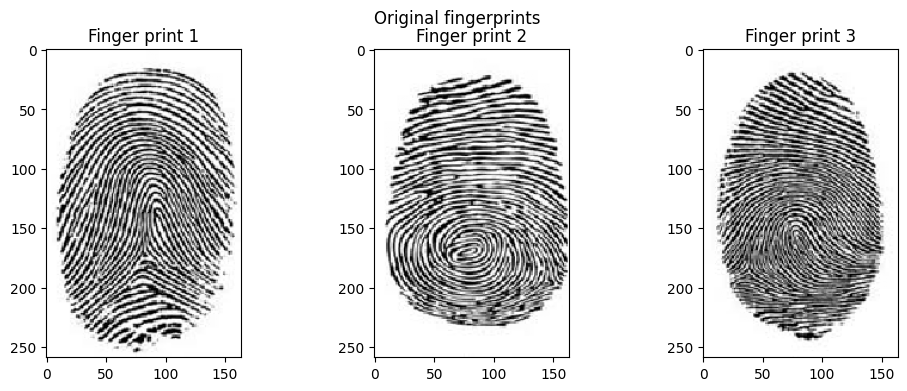

In [58]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.imshow(fp1,cmap='gray')
ax2.imshow(fp2,cmap='gray')
ax3.imshow(fp3,cmap='gray')
ax1.set_title("Finger print 1")
ax2.set_title("Finger print 2")
ax3.set_title("Finger print 3")
plt.suptitle("Original fingerprints")
plt.show()

In [26]:
# CONSTRUCT S
S = np.array([fp1.ravel(), fp2.ravel(), fp3.ravel()])
print(S.shape)

# CONSTRUCT A1, A2

A1 = np.array([[5, 10, 0],
              [10, 0, 40],
              [0, 18, 50]])


A2 = np.array([[1, 1, 0],
              [0, 1, 1],
              [1, 0, 1]])

(3, 42476)


* $\mathbf{X}=\mathbf{A} \mathbf{S}$ is a $3\times n$ matrix with mixed signals. Reshape each row of $\mathbf{X}$ back to $h\times w$ and plot as grayscale image.

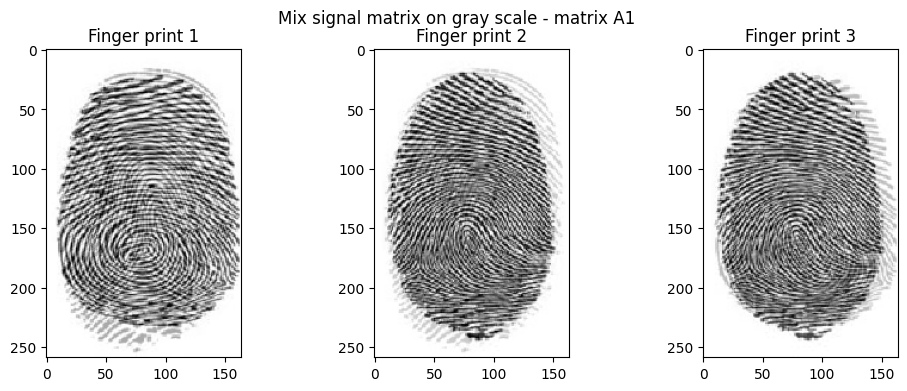

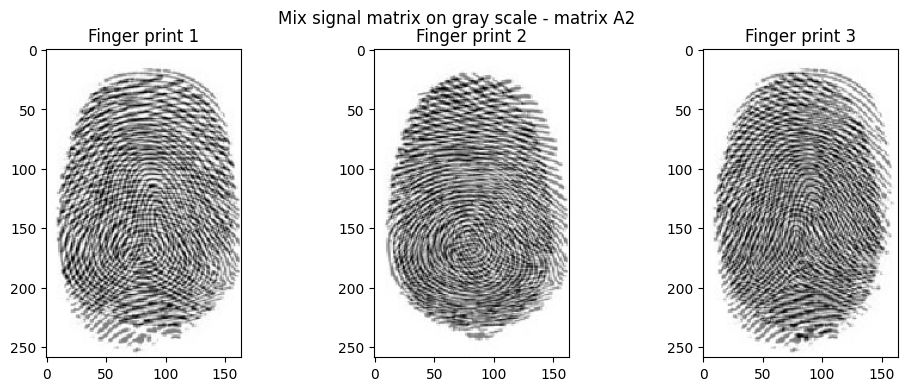

In [57]:
# DRAW MIX SIGNAL MATRIX (X = A @ S) IN GRAY SCALE

X1 = A1 @ S
X2 = A2 @ S


def draw_mix_signal_matrix(X, str_name_A="A1"):
    fig = plt.figure(figsize=(12, 4))
    fig.suptitle(f"Mix signal matrix on gray scale - matrix {str_name_A}")

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title("Finger print 1")
    ax1.imshow(X[0, :].reshape(h, w), cmap=plt.get_cmap('gray'))

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_title("Finger print 2")
    ax2.imshow(X[1, :].reshape(h, w), cmap=plt.get_cmap('gray'))

    ax2 = fig.add_subplot(1, 3, 3)
    ax2.set_title("Finger print 3")
    ax2.imshow(X[2, :].reshape(h, w), cmap=plt.get_cmap('gray'))

    plt.show()


draw_mix_signal_matrix(X1)
draw_mix_signal_matrix(X2, "A2")

* Using ICA try to reconstruct $\mathbf{S}$ from $\mathbf{X}$. Were you able to reconstruct at least one fingerprint? Try also normalizing $\mathbf{X}$ first (e.g., each row to have mean 0 and std=1). Display reconstructed sources (as images) and also as binary images (with threshold = mean of image)

In [49]:
def do_reconstruction_S_ICA(X, normalized=True):
    if normalized:
        ica = FastICA(whiten=False)
        X_norm = normalize(X)
        S_reconstructed = ica.fit_transform(X_norm.T).T  # Reconstruct signals
    else:
        ica = FastICA(n_components=3, whiten='arbitrary-variance')
        S_reconstructed = ica.fit_transform(X.T).T

    return S_reconstructed

In [54]:
def draw_reconstructed_S_ICA(X, str_name_A="A1", normalized=True):
    fig = plt.figure(figsize=(12, 4))

    S_reconstructed = do_reconstruction_S_ICA(X, normalized)

    if normalized:
        fig.suptitle(f"Reconstructed S from ICA {str_name_A} with normalizing")
    else:
        fig.suptitle(f"Reconstructed S from ICA ({str_name_A}) without normalizing")

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(S_reconstructed[0, :].reshape(h, w), cmap=plt.get_cmap('gray'))

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(S_reconstructed[1, :].reshape(h, w), cmap=plt.get_cmap('gray'))

    ax2 = fig.add_subplot(1, 3, 3)
    ax2.imshow(S_reconstructed[2, :].reshape(h, w), cmap=plt.get_cmap('gray'))

    plt.show()

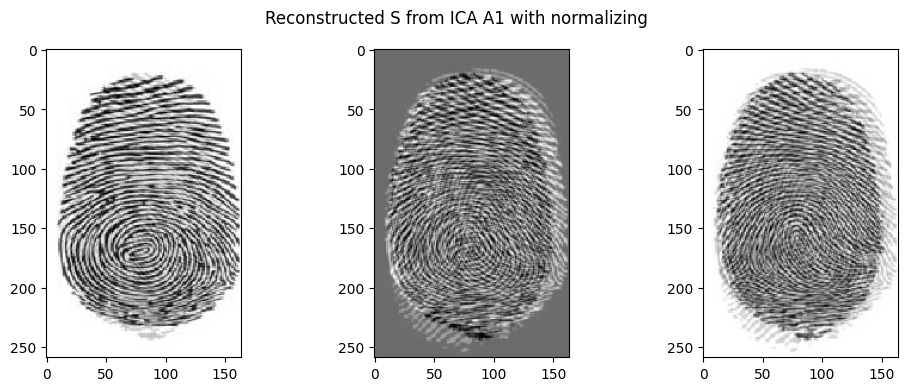

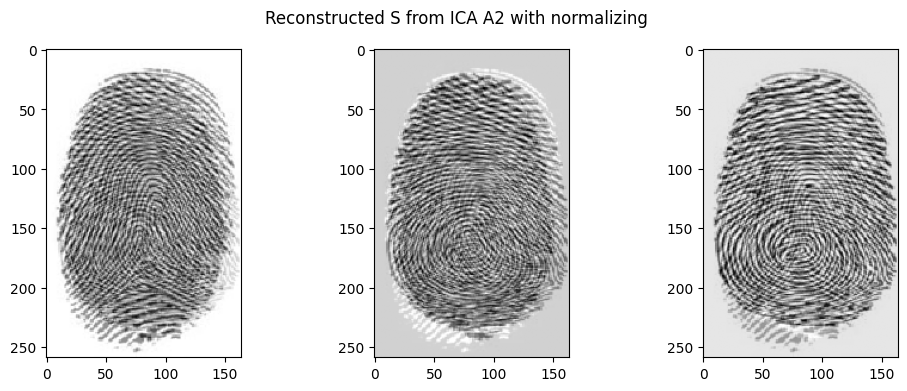

In [55]:
# ICA WITH NORMALIZING
draw_reconstructed_S_ICA(X1)
draw_reconstructed_S_ICA(X2, str_name_A="A2")

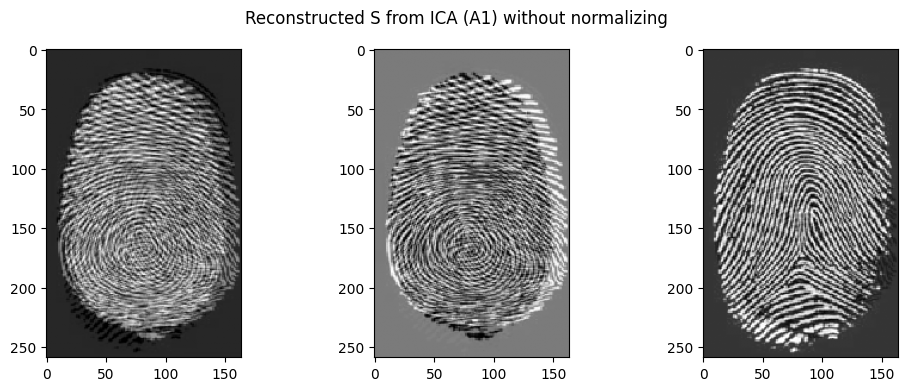

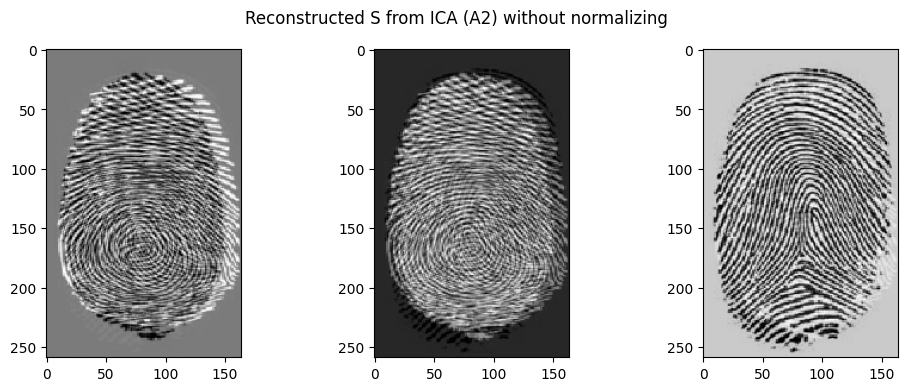

In [56]:
# ICA WITHOUT NORMALIZING
draw_reconstructed_S_ICA(X1, normalized=False)
draw_reconstructed_S_ICA(X2, str_name_A="A2", normalized=False)

In [66]:
def draw_binary_images(S_recovered, h, w, str_name_A="A1", normalized=True):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    if normalized:
      fig.suptitle(f"Reconstructed S from ICA ({str_name_A}) with normalizing")
    else:
      fig.suptitle(f"Reconstructed S from ICA ({str_name_A}) without normalizing")

    for i in range(3):
        img = S_recovered[i, :].reshape([h, w])
        threshold = img.mean()
        binary_image = (img > threshold) * 255  # 255 - white, 0 - black

        axes[i].imshow(binary_image, cmap='gray')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

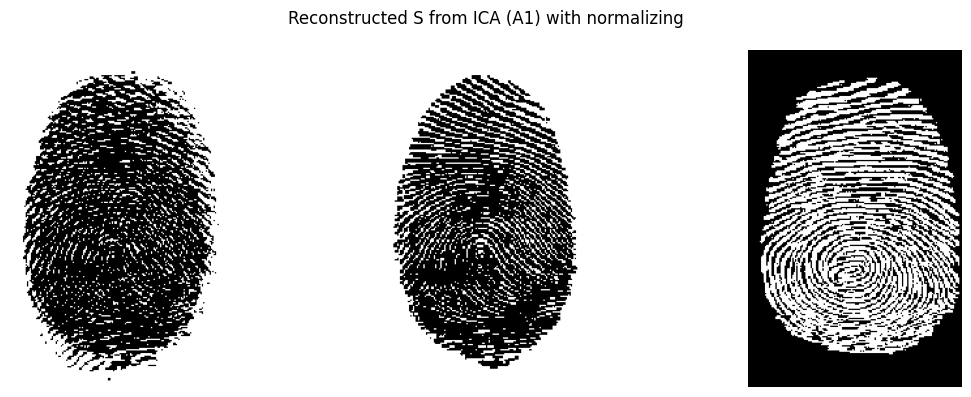

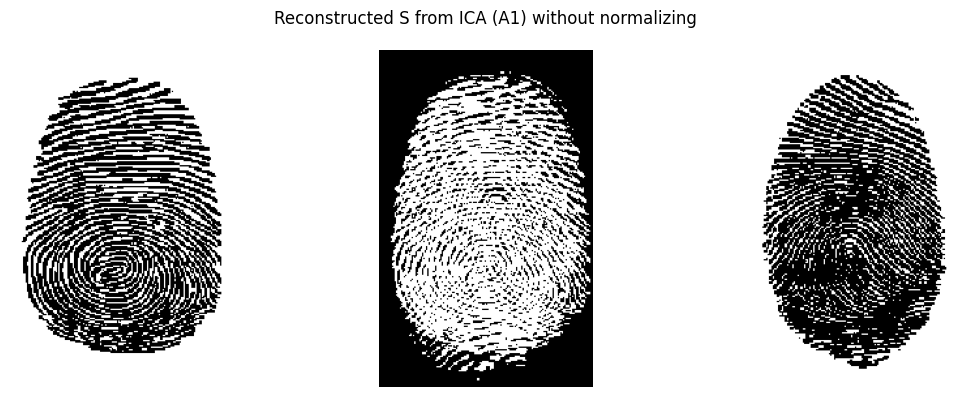

In [69]:
# FROM X1
S_recovered_norm = do_reconstruction_S_ICA(X1, normalized=True)
S_recovered_nonorm = do_reconstruction_S_ICA(X1)

draw_binary_images(S_recovered_norm, h, w)
draw_binary_images(S_recovered_nonorm, h, w, normalized=False)

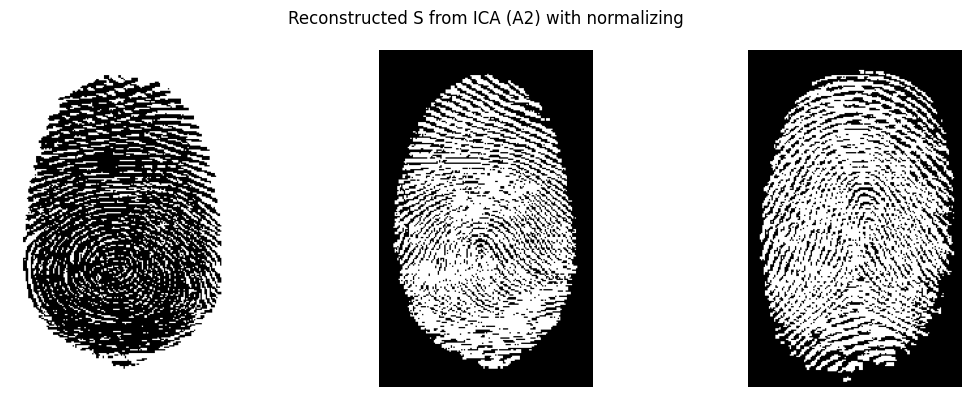

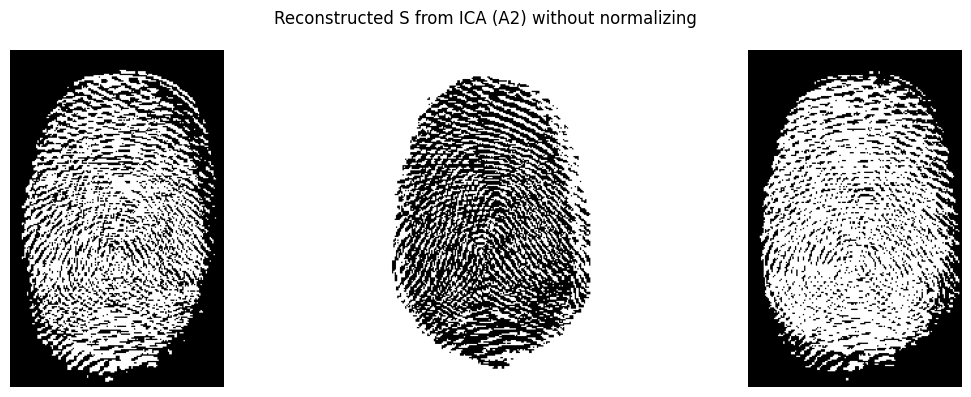

In [68]:
# FROM X2

S_recovered_norm2 = do_reconstruction_S_ICA(X2, normalized=True)
S_recovered_nonorm2 = do_reconstruction_S_ICA(X2)

draw_binary_images(S_recovered_norm2, h, w, str_name_A = "A2")
draw_binary_images(S_recovered_nonorm2, h, w, str_name_A = "A2", normalized=False)

# Q3.3 (**10 pts**)
* Select randomly 4 faces from `lfw`. Perform PCA on each image separately. Display images: 4 rows and 6 columnes: each row corresponds to one person, columns to recunstructed faces using $r=1,2,4,6,8$  and for $r$ (display its value) such that $(\lambda_1+\ldots+\lambda_r)/(\lambda_1+\ldots+\lambda_d)\geq 0.9$ (do such $r$ vary with image?)

In [75]:
# READ DATA

lfw_dataset = datasets.fetch_lfw_people()
n_all, _, _ = lfw_dataset.images.shape

np.random.seed(0)
idx = np.random.randint(1, n_all, 4)

# CHOOSE 4 PEOPLE
lfw_images = lfw_dataset.images[idx]
lfw_data_classes = lfw_dataset.target[idx]  # the person IDs
lfw_classes_names = lfw_dataset.target_names

n, h, w = lfw_images.shape
d = h * w

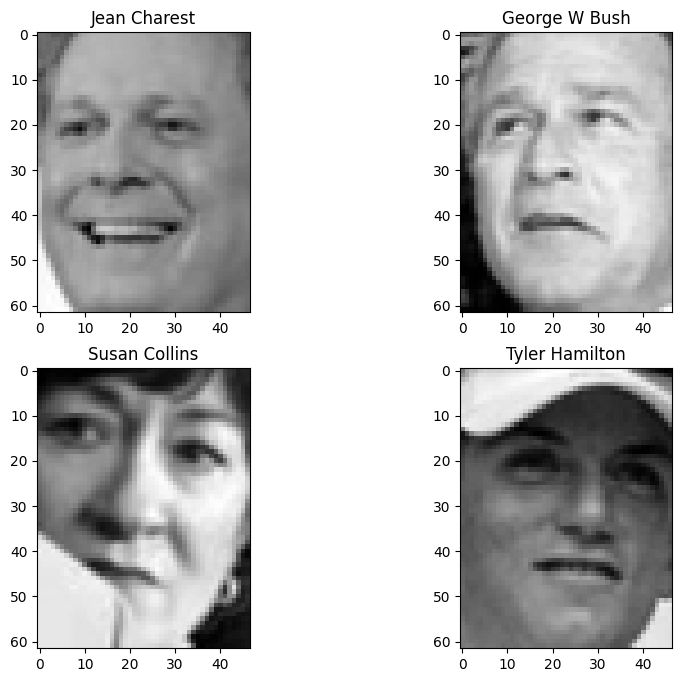

In [76]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

b = [3, 2, 1, 0]

for row in ax:
    for col in row:
        i = b.pop()
        col.imshow(lfw_images[i], cmap='gray')
        col.set_title(lfw_classes_names[lfw_data_classes[i]])

plt.show()

In [80]:
def r_component_explain_90perc(image):
    pca_model = decomposition.PCA()
    pca_model.fit(image)

    eigenvalues_model = pca_model.explained_variance_
    total_variance = np.sum(eigenvalues_model)
    cumulative_variance = np.cumsum(eigenvalues_model) / total_variance

    print(f"The minimal number of components to explain 90% of data set is {np.min(np.where(cumulative_variance >= 0.9))}")

for i in lfw_images:
  r_component_explain_90perc(i)

The minimal number of components to explain 90% of data set is 5
The minimal number of components to explain 90% of data set is 4
The minimal number of components to explain 90% of data set is 4
The minimal number of components to explain 90% of data set is 3


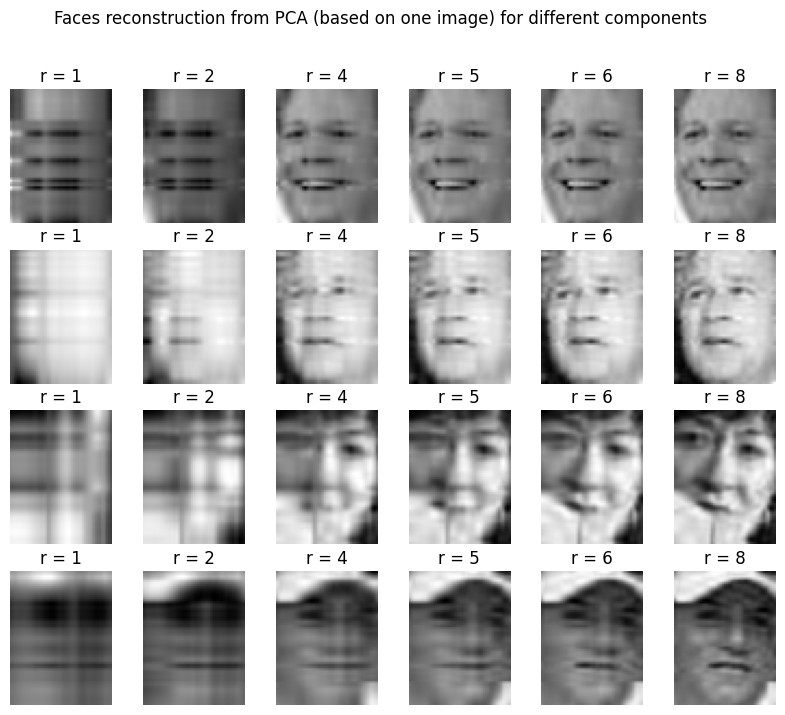

In [91]:
def draw_reconstructed_image_from_PCA(id_person, row):
    j = np.where(lfw_data_classes == id_person)[0][0]
    idxs = [8, 6, 5, 4, 2, 1]

    for col in row:
        r = idxs.pop()
        pca_model = decomposition.PCA(n_components=r)
        pca_fitted = pca_model.fit_transform(lfw_images[j])
        pca_inv_fit = pca_model.inverse_transform(pca_fitted) # back to the original (or close to the original) high-dimensional space

        col.imshow(pca_inv_fit, cmap=plt.get_cmap('gray'))
        col.set_title(f"r = {r}")
        col.axis('off')


fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(10, 8))
fig.suptitle("Faces reconstruction from PCA (based on one image) for different components")

for k in range(n):
    id_person = lfw_data_classes[k]
    draw_reconstructed_image_from_PCA(id_person, ax[k])

plt.show()

* Collect all images in one matrix of size $d\times n$. Perform PCA on such matrix. Then "recover" faces of 4 persons (the same as in previous case) using $r=1,2,4,6,8$ and common $r$ such that $(\lambda_1+\ldots+\lambda_r)/(\lambda_1+\ldots+\lambda_d)\geq 0.9$

In [85]:
# SET WITHOUT 4 CHOOSEN FACES
all_idx = np.ones(len(lfw_dataset.images), dtype=bool)
all_idx[idx] = False

lfw_images_all = lfw_dataset.images[all_idx]
lfw_targets_all = lfw_dataset.target[all_idx]

# ALL COLLECTED IMAGES WITHOUT 4 CHOOSEN FACES
collected_images = np.array([lfw_dataset.images[i].flatten() for i in range(n_all - n)])
print(collected_images.shape)

(13229, 2914)


In [86]:
r_component_explain_90perc(collected_images)

The minimal number of components to explain 90% of data set is 100


In [93]:
def draw_reconstructed_image_from_PCA_all(id_person, row):
    j = np.where(lfw_data_classes == id_person)[0][0]
    idxs = [120, 100, 8, 6, 4, 2, 1]

    for col in row:
        r = idxs.pop()
        pca_model = decomposition.PCA(n_components=r)
        pca_model.fit(collected_images)
        img_flat = lfw_images[j].flatten().reshape(1, -1)
        img_pca = pca_model.transform(img_flat)
        pca_fitted = pca_model.inverse_transform(img_pca) # back to the original (or close to the original) # high-dimensional space

        col.imshow(pca_fitted.reshape(h, w), cmap=plt.get_cmap('gray'), aspect='equal')
        col.set_title(f"r = {r}")
        col.axis('off')

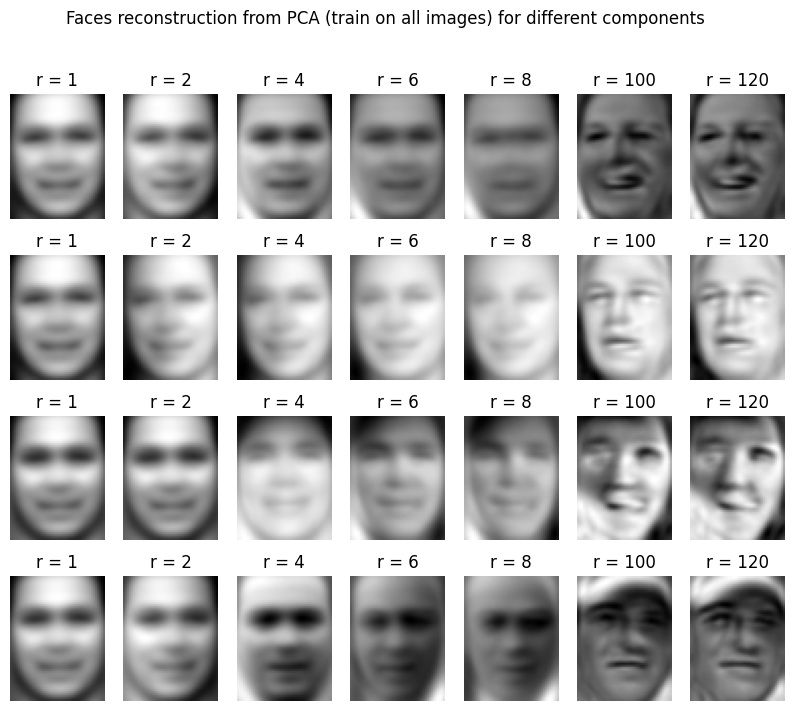

In [94]:
fig, ax = plt.subplots(nrows=4, ncols=7, figsize=(10, 8))
fig.suptitle("Faces reconstruction from PCA (train on all images) for different components")

for k in range(n):
    id_person = lfw_data_classes[k]
    draw_reconstructed_image_from_PCA_all(id_person, ax[k])

plt.show()